# Preprocessing the Yelp Comments on Berlin Restaurants

#### Get required packages

In [1]:
import pandas as pd
import re
import nltk
import string
import nltk.tokenize
#Run in Terminal
#pip install spacy
#python -m spacy download de_core_news_md
import spacy as spacy
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('german')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Get dataset

In [73]:
yelp = pd.read_csv('../1_web_scraping/german_merged.csv')
yelp.columns.values[0]="ID"
yelp = yelp.rename(columns={'Overall Rating':'Overall_Rating',
                                      "Total Reviews":'Total_Reviews',
                                      "Restaurant Name":"Restaurant_Name",
                                     "Price Range":"Price_Range"})
yelp.columns
yelp['ID'] = yelp['ID'].astype(int)
yelp['Comment'] = yelp['Comment'].astype(str)
yelp['Overall_Rating'] = yelp['Overall_Rating'].astype(float)
yelp['Date'] = yelp['Date'].astype('datetime64[ns]',"dd-MM-yyyy")
yelp.dtypes
print(yelp.info())



C:\Users\ana\AppData\Local\Temp\ipykernel_27180\455744550.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  yelp['Date'] = yelp['Date'].astype('datetime64[ns]',"dd-MM-yyyy")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9721 entries, 0 to 9720
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               9721 non-null   int32         
 1   Restaurant_Name  9721 non-null   object        
 2   Overall_Rating   9721 non-null   float64       
 3   Total_Reviews    9721 non-null   int64         
 4   Specialty        9721 non-null   object        
 5   Region           9721 non-null   object        
 6   Price_Range      9721 non-null   object        
 7   Author           9721 non-null   object        
 8   Comment          9721 non-null   object        
 9   Rating           9721 non-null   int64         
 10  Date             9721 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(6)
memory usage: 797.6+ KB
None


#### Remove Duplicates

In [74]:
print(len(yelp))
# Remove duplicates
yelp = yelp.drop_duplicates(subset=['Comment'], inplace=False)
print(len(yelp)) #15 duplicates found

9721
9706


#### Basic Cleaning

In [75]:
#remove pattern "Unknown" / "x Fotos" in Author - replace with None
yelp['Author'] = yelp.Author.where((yelp.Author == 'Unknown') | ('Foto' in yelp.Author), None)
yelp['Price_Range'] = yelp.Price_Range.where(yelp.Price_Range == 'Unknown', None)
#print(yelp[yelp.ID==1114])

def clean_text(text):
    #fix enter instead of punctuation or space but keep contiguous capitalization
    text = re.sub('(?<=.)(?=[A-Z][a-z])', r" ", text)
    #remove random urls w/o http
    text = re.sub('[\w]+\.[\w]+\/+[\w]+','',text)
    #remove URL with http
    text = re.sub(r'http\S+', '', text)
    #remove URL with www
    text = re.sub(r'www\S+', '', text)
    # add space after . to avoid word concatenation when user left no space after .
    text = re.sub(r'(?<=[.,)!])(?=[^\s])', r' ', text)
    # Remove Emoji chars
    emoticons = r'[\W]+(?::|;|=)(?:-)?(?:\)+|\(|D|P)'
    text = re.sub(emoticons, '' , text)
    #remove hashtags but leave the content of a hashtag in text
    text = re.sub(r"([#]+)", "", text)
    #remove @name shoutouts +  weird shoutouts with space between @ and name
    pattern_shoutout_one = r"((\w+|[^a-z])[@](\s+\w+|\w+|.*))"
    text = re.sub(pattern_shoutout_one, "",text)
    #Remove weird unicode characters such as U+2026
    text = re.sub(r'[^\x00-\x7FäöüÄÖÜß]+', '', text)
    # # remove hashtags and normal shoutouts with @
    # pattern_hashtags_shoutouts = r"([@#]\w+)"
    # text = re.sub(pattern_hashtags_shoutouts,"" ,text)

    #remove digits
    text = re.sub(r'[0-9]+', '', text)
    #remove 1 char words
    text = re.sub(r'\b\w{1}\b', ' ', text)
    #Remove punctuations etc.
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    #Convert to lowercase to maintain consistency
    text = text.lower()
    return text

df = yelp[['ID', 'Comment']]
pd.set_option('max_colwidth', 800)
yelp['Clean_Comment'] = yelp['Comment'].apply(lambda x: clean_text(x))

print("URL case")
print(yelp.Comment[0])
print(yelp.Comment[3562])
print("Emoji case")
print(yelp.Comment[28])
print(yelp.Comment[6])
print(yelp.Comment[226])
print(yelp.Comment[164])
print("Shoutouts")
print("1")
print(yelp.Comment[278])#remove comments in english
print("2")
print(yelp.Comment[2672])
print("3")
print(yelp.Comment[6434])
print("4")
print(yelp.Comment[2690])
print("Hashtags")
print(yelp.Comment[1134])#remove comments in english
print(yelp.Comment[4605])
print("Commentar 112 gelandetTolles")
print(yelp.Comment[112])
print(yelp.Comment[2680])

URL case
Ich habe mir Bewertungen zu Restaurants auf Menulist angesehen, und dieses Restaurant hatte gute Kritiken, also habe ich es ausprobiert und es nicht bereut.menulist.menu/restaurant…
Neue Homepage:www.http://a-telha-portugiesisches-restaurant.de/
Emoji case
Der wohl verrückteste Kellner den ich je hatte, aber eine einzigartige Kneipe die sich Hinter der Stadtklause versteckt. Im Kellergewölbe kann man auch noch sitzen. Günstiges deutsches Essen und Bier in einem eigentlich so touristisch überfluteten Potsdamer Platz Ecke ;)Gerade bei den sonst so hohen Bierpreisen in der Umgebung des Sony Center, liefert die Stadtklause eine Entspannung für den Geldbeutel. Preis-Leistung stimmt!
Super leckeres Essen!Cooles Atmosphäre !Gutes Bier!Leider keine EC Karten oder Kreditkarten aktzeptiert.Das ist ein bissle schade.
Mit Abstand das beste Schnitzel weit und breit. Super nettes Ambiente und tolles Personal, beim nächsten berlin-Besuch wieder! Daumen hoch :)
Beste Ramen die ich jemals gege

In [76]:
yelp.head()

,ID,Restaurant_Name,Overall_Rating,Total_Reviews,Specialty,Region,Price_Range,Author,Comment,Rating,Date,Clean_Comment
0,0,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,"Ich habe mir Bewertungen zu Restaurants auf Menulist angesehen, und dieses Restaurant hatte gute Kritiken, also habe ich es ausprobiert und es nicht bereut.menulist.menu/restaurant…",5,2022-10-26,ich habe mir bewertungen zu restaurants auf menulist angesehen und dieses restaurant hatte gute kritiken also habe ich es ausprobiert und es nicht bereut
1,1,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,"Das Joseph ist ein ziemlich neues, israelisches Restaurant im modernen Design. Es ist zwar nicht besonders kuschelig, aber angenehm hell und hübsch eingerichtet mit schönen Lampen. Der Service ist ausgesprochen freundlich, unkompliziert und aufmerksam, besonders Celina. Das Essen kam schnell, sah sehr appetitlich aus und so schmeckte es auch. Die israelischen Starter, Kleinigkeiten und Hauptspeisen haben uns sehr gut geschmeckt, die Preise sind angemessen und für Berlin-Mitte nicht zu teuer. Wir waren nur etwas überrascht, dass schon um 21.30 / 22h sehr laute Musik aufgelegt wurde, wir konnten uns fast nicht mehr unterhalten am 2er Tisch gegenüber. Auf Anfrage wurde das etwas gedrosselt. Fazit: Wer israelische Küche mag, gutes Preis-Leistungs-Verhältnis möchte mit Blick auf die...",4,2019-07-11,das joseph ist ein ziemlich neues israelisches restaurant im modernen design es ist zwar nicht besonders kuschelig aber angenehm hell und hübsch eingerichtet mit schönen lampen der service ist ausgesprochen freundlich unkompliziert und aufmerksam besonders celina das essen kam schnell sah sehr appetitlich aus und so schmeckte es auch die israelischen starter kleinigkeiten und hauptspeisen haben uns sehr gut geschmeckt die preise sind angemessen und für berlin mitte nicht zu teuer wir waren nur etwas überrascht dass schon um sehr laute musik aufgelegt wurde wir konnten uns fast nicht mehr unterhalten am er tisch gegenüber auf anfrage wurde das etwas gedrosselt fazit wer israelische küche mag gutes preis leistungs verhältnis möchte mit blick auf die friedri...
2,2,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,"Schalömchen, scheiße haben wir uns heute koscher weggeknallt. Maria und Joseph werden zum Vorbild. Kellerinnen geben alles und saufen mehr als der Gast. Als ich rein kam, schlägt es Wellen, aber ich bin diesen Sommer einfach lit as fuck und alle saufen mit mir. Ne geile Crew ist die halbe Miete! Hätte gerne mehr geferkelt, aber war zu dicht",5,2019-10-18,schalömchen scheiße haben wir uns heute koscher weggeknallt maria und joseph werden zum vorbild kellerinnen geben alles und saufen mehr als der gast als ich rein kam schlägt es wellen aber ich bin diesen sommer einfach lit as fuck und alle saufen mit mir ne geile crew ist die halbe miete hätte gerne mehr geferkelt aber war zu dicht
3,3,JOSEPH,4.5,6,Israelisch /,Mitte,Unknown,None,"Essen war allenfalls ok, muss ich nicht nochmal haben. Insgesamt war mein Erlebnis im Joseph sehr langweilig. Nachdem ich allein ins Restaurant kam, dauerte es erstmal, bis ich begrüßt und platziert wirde. Das Lokal war nicht voll, die Speisekarte auf Englisch (was mich in Berlin Mitte nicht wirklich verwundert).Ich bestellte einen Grüne-Bohnen-Salat als Vorspeise und danach einen Grillspieß mit Gemüse. In der offenen Küche zubereitet, kam es nach wenigen Minuten am Tisch an. Sellerie und Walnüsse, die lt. Karte unter Anderem in meinem wohl klingenden Salat sein sollten, fehlten. Der selbstgemachte Bagel als Beilage zum Salat hingegen hat mir gut geschmeckt. Der Grillspieß bestand aus Kartoffel, Zwiebel, Aubergine, Paprika und Zucchini - gebettet auf stellenweise schwarz verkohltem Fla...",2,2020-08-01,essen war allenfalls ok muss ich nicht nochmal haben insgesamt war mein erlebnis im joseph sehr langweilig nachdem ich allein ins restaurant kam dauerte es erstmal bis ich begrüßt und platziert wirde das lokal war nicht voll die speisekarte auf englis

#### Tokenization & Stopword Removal

In [77]:

def tokenize_and_remove_stopword(text):
    tokens = word_tokenize(text,language='german')
    text = " ".join([word for word in tokens if word not in stop_words])
    return text

yelp['Tokenized_Comment'] = yelp['Clean_Comment'].apply(lambda x: tokenize_and_remove_stopword(x))
print(yelp.Comment[7890])
print(yelp.Comment[112])

Wir sind alle 2-3 Monate in der Schnitzelei, die (sehr großen) Schnitzel sind sehr lecker und die Karte ist kreativ zusammengestellt. Insbesondere das kostenlose Begrüßungsbier und die deutschen Tapas heben die Schnitzelei nochmal von anderen Lokalen ab. Zudem sind alle Bedienungen sehr freundlich und das Ambiente ist sehr angenehm.
durch Zufall sind wir auf das Marral gelandetTolles Essen, toller Service und alles auch noch zu einem guten Preis. Wir kommen defintiv wieder


#### Lemmatisierung mit SpaCy

In [78]:
# https://blog.codecentric.de/natural-language-processing-basics
# https://textmining.wp.hs-hannover.de/Preprocessing.html
# https://nickyreinert.de/blog/2020/12/09/einfuehrung-in-stemming-und-lemmatisierung-deutscher-texte-mit-python/
# https://de.steadforce.com/blog/natural-language-processing-tools
# https://spacy.io/usage/linguistic-features#lemmatization

In [79]:
#pip install spacy
#python -m spacy download de_core_news_md

In [80]:
spc =  spacy.load(r'de_core_news_md')

def lemmatize_spc(tokenized_comment):

    tok_cmt_as_spacy_object = spc(tokenized_comment)
    text = " ".join([token.lemma_ for token in tok_cmt_as_spacy_object])
    return text.lower()
yelp['Lemmatized_Comment'] = yelp['Tokenized_Comment'].apply(lambda x: lemmatize_spc(x))





#### Drop Columns and Save to CSV

In [81]:
yelp.drop(["ID", "Restaurant_Name", "Overall_Rating", "Total_Reviews", "Specialty", "Region", "Author", "Date", "Price_Range"],inplace = True,axis = 1)
yelp.to_csv("cleaned_data_yelp.csv", index=False)

In [82]:
print(yelp['Lemmatized_Comment'][1:2])

1    joseph ziemlich neu israelisch restaurant modern design besonders kuschelig angenehm hell hübsch einrichten schön lampe service ausgesprochen freundlich unkompliziert aufmerksam besonders celina essen kommen schnell sehen appetitlich schmeckt israelisch starter kleinigkeit hauptspeise gut schmecken preis angemessen berlin mitte teuer überraschen schon laut musik auflegen werden können fast mehr unterhalt tisch gegenüber anfrage werden drosseln fazit wer israelisch küche mögen gut preis leistung verhältnis möchten blick friedrichstraße nett service gut aufheben
Name: Lemmatized_Comment, dtype: object


C:\Users\ana\AppData\Local\Temp\ipykernel_27180\2192331298.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(yelp['Lemmatized_Comment'][1:2])


# Data Visualization: Data Description and Distribution

[5, 4, 3, 2, 1]
5    4595
4    2762
3    1257
2     602
1     490
Name: Rating, dtype: int64


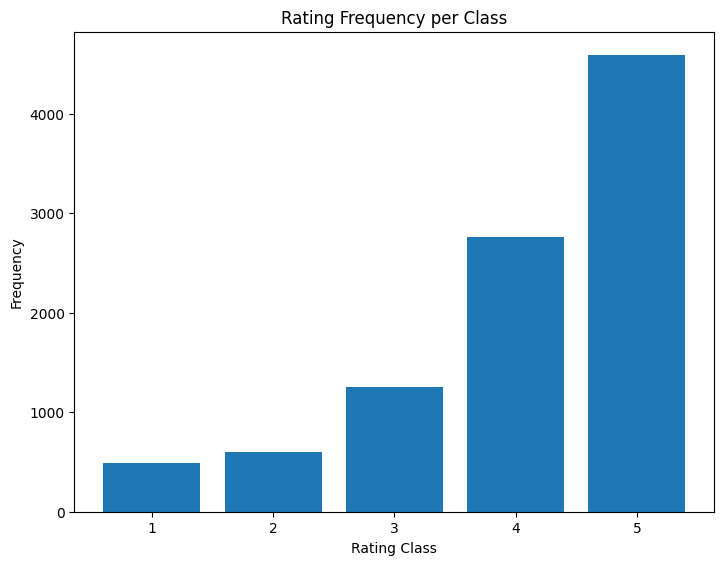

In [12]:
import matplotlib.pyplot as plt
yelp = pd.read_csv("cleaned_data_yelp.csv")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ratings = sorted(list(yelp['Rating'].unique()), reverse=True)
print(ratings )
freq =  (yelp['Rating'].value_counts())
plt.title("Rating Frequency per Class")
plt.ylabel("Frequency")
plt.xlabel("Rating Class")
print(freq)
ax.bar(ratings,freq)
plt.show()

In [84]:
import numpy as np
# Get subset Datasets per Rating class for plots by class
# Count number of tokens per Comment
yelp = pd.read_csv('cleaned_data_yelp.csv')
def compute_length(text):
    tokens = nltk.word_tokenize(text)
    length_in_tokens = len(tokens)
    return length_in_tokens
yelp['Number_Tokens']= yelp['Tokenized_Comment'].apply(lambda x: compute_length(x))


yelp1 =pd.DataFrame(yelp[yelp.Rating==1])
yelp2 =pd.DataFrame(yelp[yelp.Rating==2])
yelp3 =pd.DataFrame(yelp[yelp.Rating==3])
yelp4 =pd.DataFrame(yelp[yelp.Rating==4])
yelp5 =pd.DataFrame(yelp[yelp.Rating==5])



In [85]:
# Get descriptive stats from Comment length
yelp['Number_Tokens'].describe()

count    9706.000000
mean       44.220070
std        43.364646
min         1.000000
25%        17.000000
50%        31.000000
75%        56.000000
max       417.000000
Name: Number_Tokens, dtype: float64

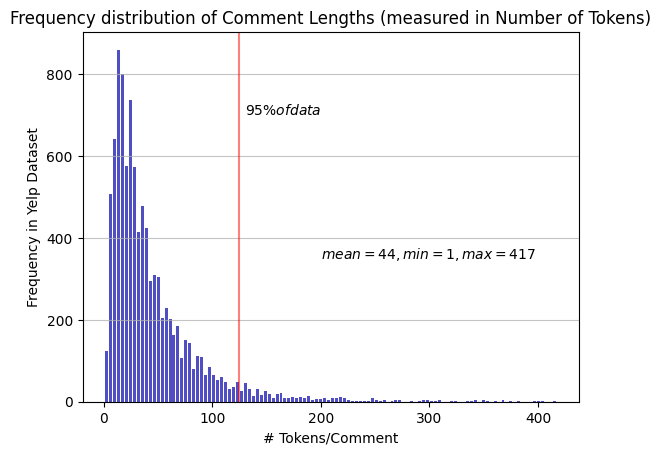

In [86]:


## Create Plot
n, bins, patches = plt.hist(x=yelp.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 700, r'$95 \% of data$')

plt.ylabel('Frequency in Yelp Dataset')
plt.title('Frequency distribution of Comment Lengths (measured in Number of Tokens)')
plt.text(200, 350, r'$mean=44, min=1, max=417$')
maxfreq = n.max()
# Set a clean upper y-axis limit.

#### Comment length per Rating class

In [87]:
## Create Plot for Rating 1
yelp1.describe()

,Rating,Number_Tokens
count,490.0,490.000000
mean,1.0,59.402041
std,0.0,53.738932
min,1.0,1.000000
25%,1.0,22.000000
50%,1.0,42.000000
75%,1.0,81.000000
max,1.0,359.000000


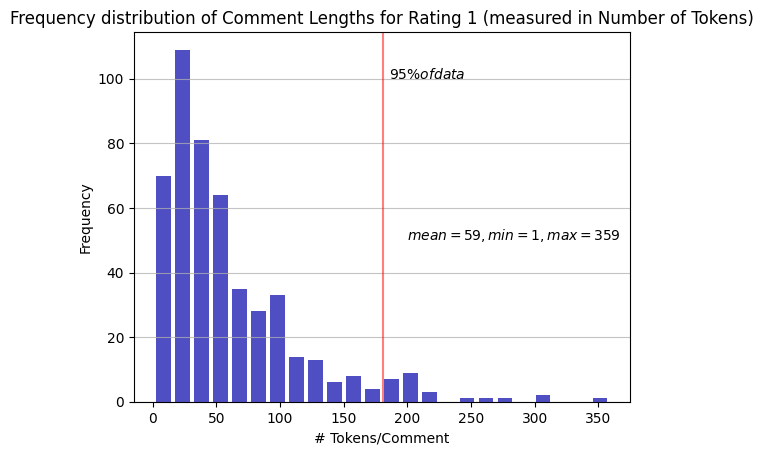

In [88]:
n, bins, patches = plt.hist(x=yelp1.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp1['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 100, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 1 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=59, min=1, max=359$')
maxfreq = n.max()

In [89]:
## Create Plot for Rating 2
yelp2.describe()

,Rating,Number_Tokens
count,602.0,602.000000
mean,2.0,60.870432
std,0.0,50.053381
min,2.0,2.000000
25%,2.0,26.000000
50%,2.0,46.000000
75%,2.0,79.000000
max,2.0,342.000000


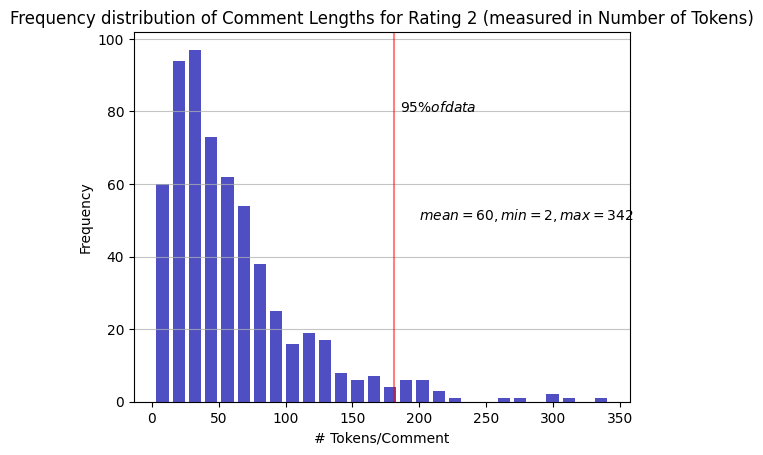

In [90]:
n, bins, patches = plt.hist(x=yelp2.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp1['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 80, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 2 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=60, min=2, max=342$')
maxfreq = n.max()

In [91]:
yelp3.describe()

,Rating,Number_Tokens
count,1257.0,1257.000000
mean,3.0,53.728719
std,0.0,45.407764
min,3.0,3.000000
25%,3.0,23.000000
50%,3.0,41.000000
75%,3.0,69.000000
max,3.0,381.000000


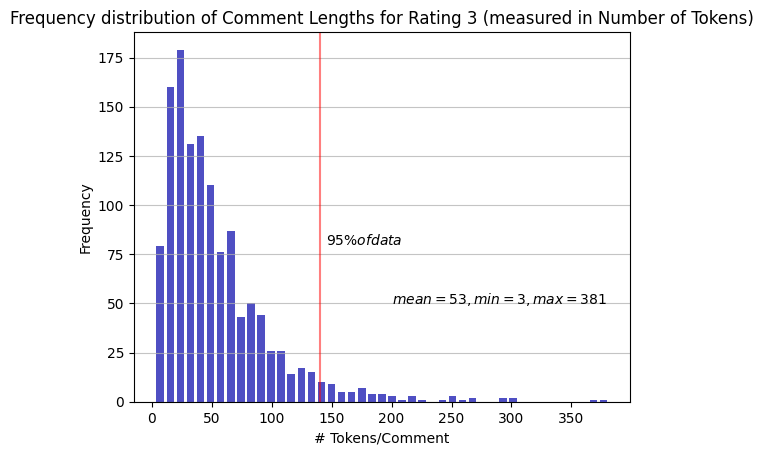

In [92]:
n, bins, patches = plt.hist(x=yelp3.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp3['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 80, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 3 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=53, min=3, max=381$')
maxfreq = n.max()

In [93]:
yelp4.describe()

,Rating,Number_Tokens
count,2762.0,2762.000000
mean,4.0,43.775887
std,0.0,42.529357
min,4.0,2.000000
25%,4.0,17.000000
50%,4.0,31.000000
75%,4.0,55.000000
max,4.0,403.000000


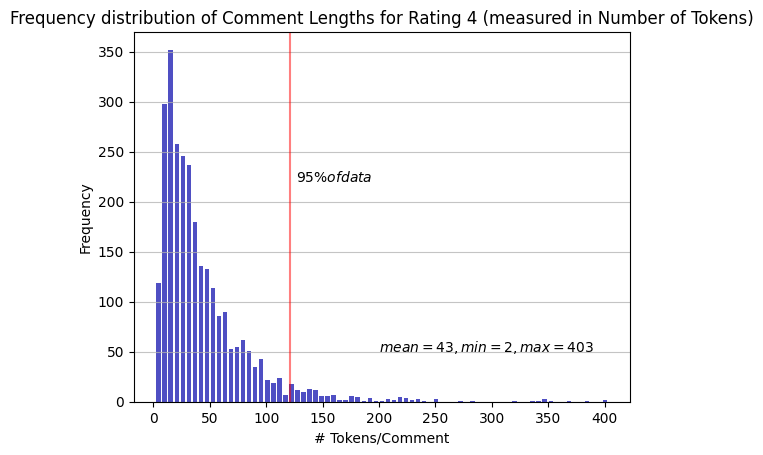

In [94]:
n, bins, patches = plt.hist(x=yelp4.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp4['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 220, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 4 (measured in Number of Tokens)')
plt.text(200, 50, r'$mean=43, min=2, max=403$')
maxfreq = n.max()

In [95]:
yelp5.describe()

,Rating,Number_Tokens
count,4595.0,4595.000000
mean,5.0,38.085528
std,0.0,39.538300
min,5.0,1.000000
25%,5.0,15.000000
50%,5.0,26.000000
75%,5.0,47.000000
max,5.0,417.000000


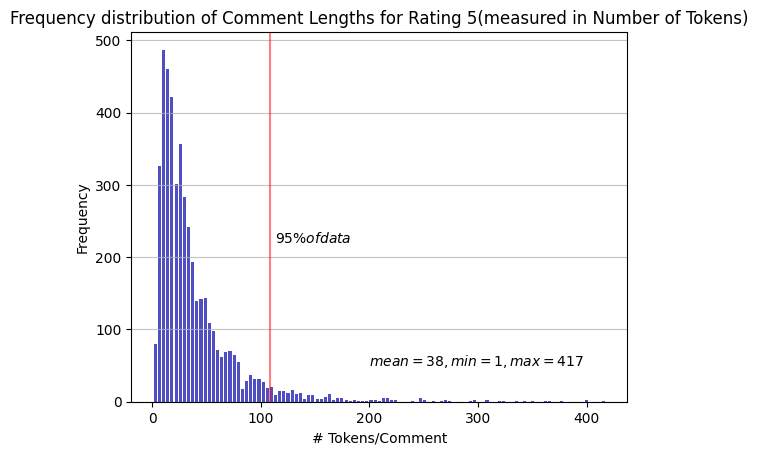

In [96]:
n, bins, patches = plt.hist(x=yelp5.Number_Tokens, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.75)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('# Tokens/Comment')

q95= yelp5['Number_Tokens'].quantile(q=0.95)
plt.axvline(q95, color='red',alpha=0.5)
plt.text(q95+5, 220, r'$95 \% of data$')

plt.ylabel('Frequency')
plt.title('Frequency distribution of Comment Lengths for Rating 5(measured in Number of Tokens)')
plt.text(200, 50, r'$mean=38, min=1, max=417$')
maxfreq = n.max()

### Word Clouds

1


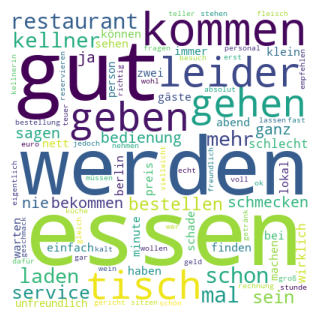

2


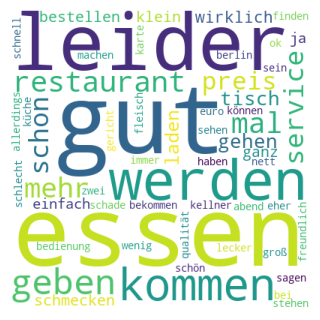

3


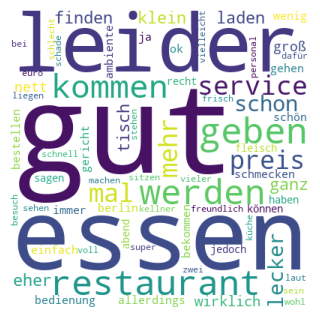

4


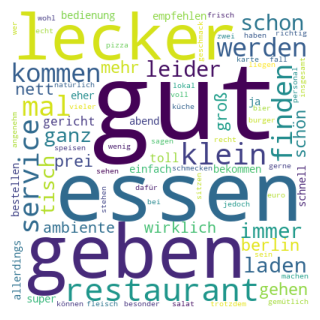

5


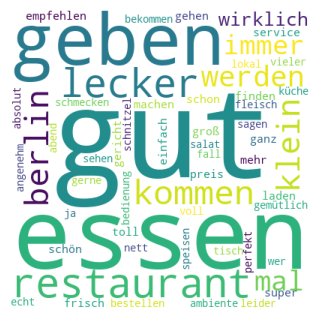

In [97]:
from wordcloud import WordCloud
def print_wordCloud(rating,comment):
    print(rating)
    wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          min_font_size = 10).generate(comment)
    plt.figure(figsize = (3, 3), facecolor = 'white', edgecolor='blue')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def make_string(rating):
    summary_str = ""
    for row_index,row in yelp[yelp['Rating']==rating].iterrows():
        summary_str += " " + row['Lemmatized_Comment']
    return summary_str

ratings = sorted(yelp["Rating"].unique().tolist())
for rating in ratings:
    post_comment = make_string(rating)
    print_wordCloud(rating,post_comment)

In [ ]:
print(yelp[["Comment","Tokenized_Comment","Lemmatized_Comment", "Rating"]][6784:6785]) # Rating =1 // wollte wohl schlecht sagen......

In [118]:
print(yelp["Comment"][8902]) # Rating =1 , ambige Sätze

Mein erster Besuch in dieser Lokalität endete mit einem wohligen Sättigungsgefühl. Als ich den Laden erneut aufsuchte, staunte ich nicht schlecht - er hatte sich um das DREIFACHE vergrößert! Als mir die imposante Platte für Zwei serviert wurde, merkte ich am Schluss des Speisens, dass es das letzte Mal irgendwie mehr gewesen sein musste. Ich vermisste diverse Leckereien, an denen ich mich labte. Enttäuschend war auch der meine Begleitung und mich ewig dutzende Service - so was möchte ich in einem Restaurant einfach nicht haben. Unfassbar fand ich jedoch, als ich den Brotkorb, welchen ich noch mal befüllen ließ, mit auf der Rechnung fand. So etwas habe ich bisher in keinem Restaurant erlebt. Der Salat, der die Grundlage auf dem Riesenteller bildete, schien auch alles andere, als sauber. UND DAS BEI DER MOMENTANEN EHEC-PARANOIA!!


In [124]:
print(yelp["Comment"][1925]) #Denglisch.... #Rating 4

Gefangen im Faradeyischrn Käfig begann unsere Reise in die Asiatische Küche.Die Preise eben so Hoch wie die Qualität der Speisen.Der Umwelt zu liebe nehmen wir auch umknickende Papierstrohhalme in Kauf.Die Toiletten sind sehr sauber was bei dieser Preisspanne ein wichtiger Indikator ist.Alles in allem ist der Name Programm and we had a good Time.


In [115]:
# Kommentar
print(yelp[yelp["Number_Tokens"]<=2][["Rating",'Comment',"Number_Tokens"]])

              Comment Tokenized_Comment Lemmatized_Comment  Rating
6784  Schleckt..!!!!!          schleckt          schlecken       1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Comment  \
8902  Mein erster Besuch in dieser Lokalität endete mit e

In [111]:
print(yelp["Comment"][4824]) # hahahahahahahahahahahahaha

MARIA und/oder JOSEPH? In der Potsdamer Straße war ich das letzte mal vor Jahren. Nachts kurz nach Zwölf. Ich war abgebrannt und sah plötzlich die Lichtreklame der Commerzbank. Bin dann rein, um nach zu sehen, ob noch ein bissel Kontokorrent übrig wäre. Ein Wunder war geschehen. Ich war im Plus und hätte mir von dem Plus drei Fahrräder kaufen können. Ich weis heute noch nicht, woher sich dieser Betrag auf mein Konto verirrt hat. Es muß ein Schutzengel gewesen sein. Aus diesem denkwürdigen Grund habe ich die Potsdamer Straße in angenehmer Erinnerung, obwohl ich nicht mehr die Erinnerung habe, wie ich damals wieder nach Hause gekommen bin. Ich war dort in der Potsdamer Straße versackt. Gestern war ein ähnlicher denkwürdiger Tag, weil ich unerwartet einige größere Engelfotos nach den USA verkauft hatte und das Salär dafür plötzlich und unerwartet einschlug. Da kam mir die Potsdamer Straße in den Sinn, das zu feiern. Na und dann kam mir ein Devotionalienladen aus der Potsdamer Straße in me